In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

C:\Users\chris\anaconda4\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.xwydx2ikjw2nmtwsfyngfuwkqu3lytcz.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# reading data
greece_inflation = pd.read_csv('Inflation and Parameters.csv', index_col=0)
greece_inflation.head()

,Cpi,Food Price Index,Energy Price Index,Hicp,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,,
2001-01-01,0.001806,0.016060,0.111474,0.003837,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.000000,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.036626,0.008565,0.077760,0.042722,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.054424,0.003301,0.082858,0.063443,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.062677,0.009190,0.087208,0.072909,0.117409,0.029163,0.025907,0.352209,0.054301


In [3]:
# with the function generate_sequences we create the appropriate sequences for training the model
def generate_sequences(time_series, n_steps):
    window, output = list(), list()
    
    for i in range(len(time_series)):

        # n_steps is the number of previous months we use so
         # predict the next month
        window_limit = i + n_steps

        # as soon as we make the last sequence, the function
         # returns the set of sequences
        if window_limit > len(time_series):
            break

        # we store each sequence in a list, which are the input of the model
         # At the same time, we store the target value in a separate list
        input_features, output_features = time_series[i:window_limit,:], time_series[window_limit-1,0]

        window.append(input_features)
        output.append(output_features)
        
    return np.asarray(window).astype('float32'), np.asarray(output).astype('float32')

In [4]:
# indexes and external data
greece_inflation.columns

Index(['Cpi', 'Food Price Index', 'Energy Price Index', 'Hicp',
       'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci'],
      dtype='object')

In [6]:
# indexes and external data
cols = ['Cpi', 'Food Price Index', 'Energy Price Index', 'Hicp','Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']

In [7]:
greece_inflation_multi = greece_inflation.loc[:, greece_inflation.columns.intersection(cols)]
greece_inflation_multi = greece_inflation_multi.apply(pd.to_numeric, errors='coerce')

In [8]:
greece_inflation_multi = greece_inflation_multi.fillna(method='bfill')
(greece_inflation_multi).isna().sum()

Cpi                   0
Food Price Index      0
Energy Price Index    0
Hicp                  0
Unemployment Rate     0
Gdp                   0
Rent Price            0
House Prices          0
Lci                   0
dtype: int64

In [9]:
# separate the external data and the indexes we want to predict
inflation_indexes = ['Cpi', 'Hicp']
external_factors = ['Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']

In [10]:
# creation of CPI dataset with the external data
cpi_inflation = greece_inflation_multi.loc[:, greece_inflation_multi.columns.intersection(['Food Price Index',
                                                                                           'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci', 'Cpi'])]

In [11]:
# creation of HICP dataset with the external data
hicp_inflation = greece_inflation_multi.loc[:, greece_inflation_multi.columns.intersection(['Food Price Index',
                                                                                           'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci', 'Hicp'])]

In [12]:
cpi_inflation

,Cpi,Food Price Index,Energy Price Index,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,
2001-01-01,0.001806,0.016060,0.111474,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.036626,0.008565,0.077760,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.054424,0.003301,0.082858,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.062677,0.009190,0.087208,0.117409,0.029163,0.025907,0.352209,0.054301
...,...,...,...,...,...,...,...,...
2021-12-01,0.841888,0.718415,0.584965,0.235830,0.531242,0.232332,0.305757,0.318080
2022-01-01,0.834924,0.776499,0.645731,0.261134,0.567558,0.235046,0.303382,0.303234
2022-02-01,0.864844,0.843772,0.713431,0.253036,0.595143,0.236799,0.314397,0.319300


In [13]:
hicp_inflation = hicp_inflation.reindex(columns=(['Hicp','Food Price Index','Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']))
hicp_inflation.head()

,Hicp,Food Price Index,Energy Price Index,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,
2001-01-01,0.003837,0.016060,0.111474,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.042722,0.008565,0.077760,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.063443,0.003301,0.082858,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.072909,0.009190,0.087208,0.117409,0.029163,0.025907,0.352209,0.054301


In [14]:
datasets = [cpi_inflation, hicp_inflation]

In [15]:
# CNN implementation to predict the two indexes
def CNN():
    
    preds = []
    tests = []

    for data in datasets:

        # building the sequence
        window, output = generate_sequences(np.asarray(data), n_steps)

        n_features= window.shape[2]

        # Split the data into train and test
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        # multivariate CNN model
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=6, input_shape=(n_steps, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # model fit
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        # prediction based on test data
        pred = model.predict(test_X, verbose=0)
        
        # creation of the actual and predicted values lists
        preds.append(preds)
        tests.append(tests)

        # calculation of error metrics
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate CNN MSE for [" + str(data.columns[0]) + "]:" + str(mse_ucnn))
        print("Multivariate CNN RMSE for [" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
        print("Multivariate CNN MAE for [" + str(data.columns[0]) + "]:" + str(mae_ucnn))

        title = "Multivariate CNN for [" + str(data.columns[0]) + "]"

        # creation of the diagrams of the actual and predicted data
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='red')
        plt.show()
        
    return preds, tests

Multivariate CNN MSE for [Cpi]:0.0013006676
Multivariate CNN RMSE for [Cpi]:0.03606477014219976
Multivariate CNN MAE for [Cpi]:0.026213376


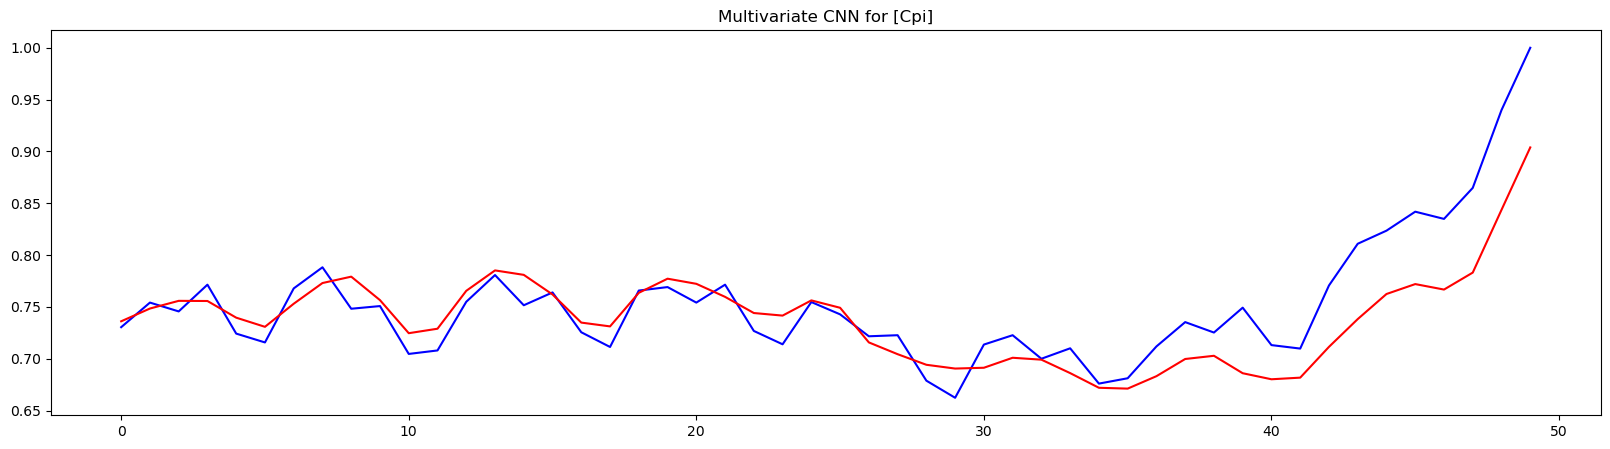

Multivariate CNN MSE for [Hicp]:0.003533431
Multivariate CNN RMSE for [Hicp]:0.05944267066680685
Multivariate CNN MAE for [Hicp]:0.05230634


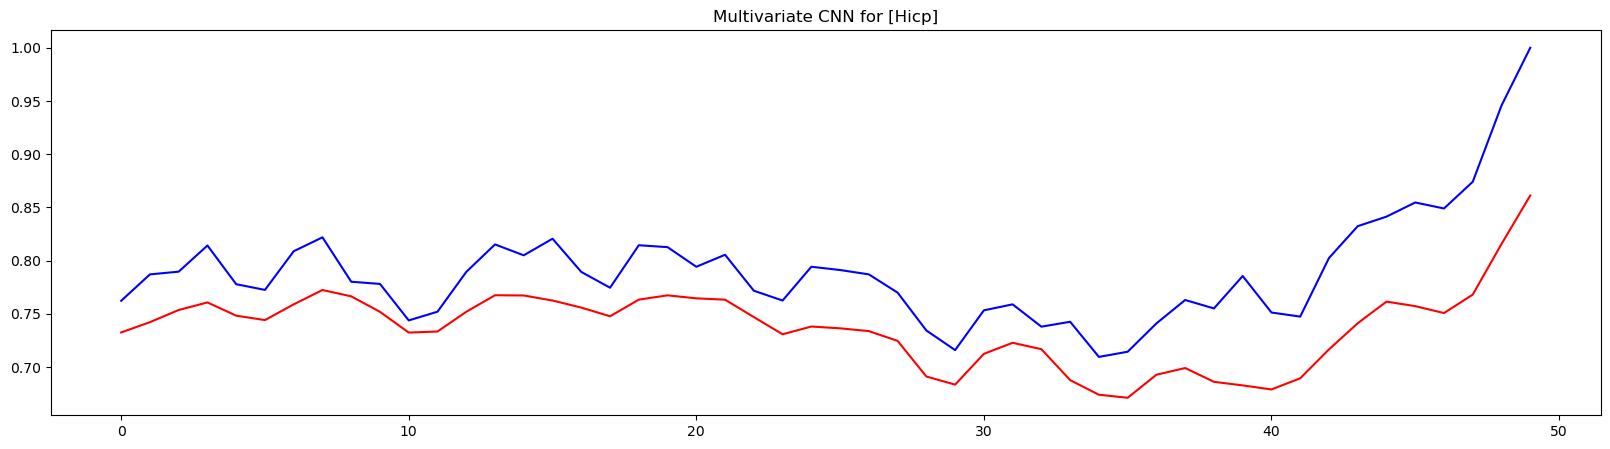

In [16]:
# declaration of the steps to create the sequences
n_steps=7

pred_mcnn,test_mcnn = CNN()

In [17]:
# impact of each external data set on each index
cols = ['Food Price Index','Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']
def CNN_for_each_index():
    
    for col in cols:
        
        cpi_cols = ['Cpi']
        cpi_cols.append(col)
        print('Cpi cols are', cpi_cols)     
        
        hicp_cols = ['Hicp']
        hicp_cols.append(col)
        print('Hicp cols are', hicp_cols)
        print('\n')
        
        cpi_inflation_values = cpi_inflation[cpi_cols]
        hicp_inflation_values = hicp_inflation[hicp_cols]
        
        datasets = [cpi_inflation_values, hicp_inflation_values]
        CNN()
        
        print('\n\n')

Cpi cols are ['Cpi', 'Food Price Index']
Hicp cols are ['Hicp', 'Food Price Index']


Multivariate CNN MSE for [Cpi]:0.0032773062
Multivariate CNN RMSE for [Cpi]:0.057247761634078825
Multivariate CNN MAE for [Cpi]:0.04538717


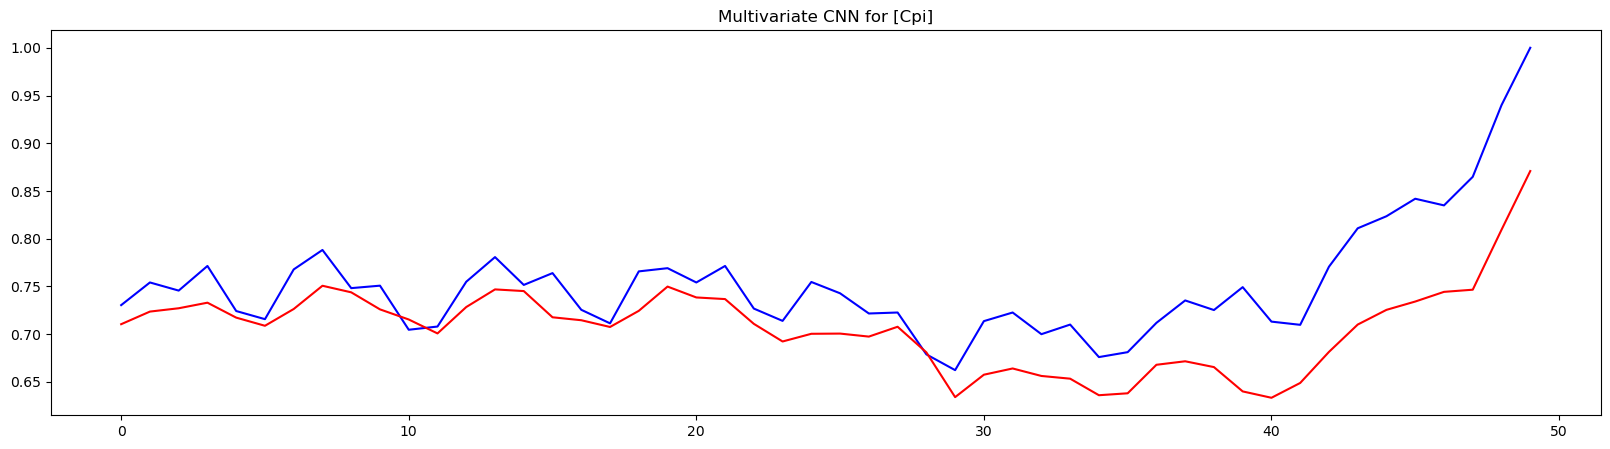

Multivariate CNN MSE for [Hicp]:0.0012099039
Multivariate CNN RMSE for [Hicp]:0.034783672285581414
Multivariate CNN MAE for [Hicp]:0.024013849


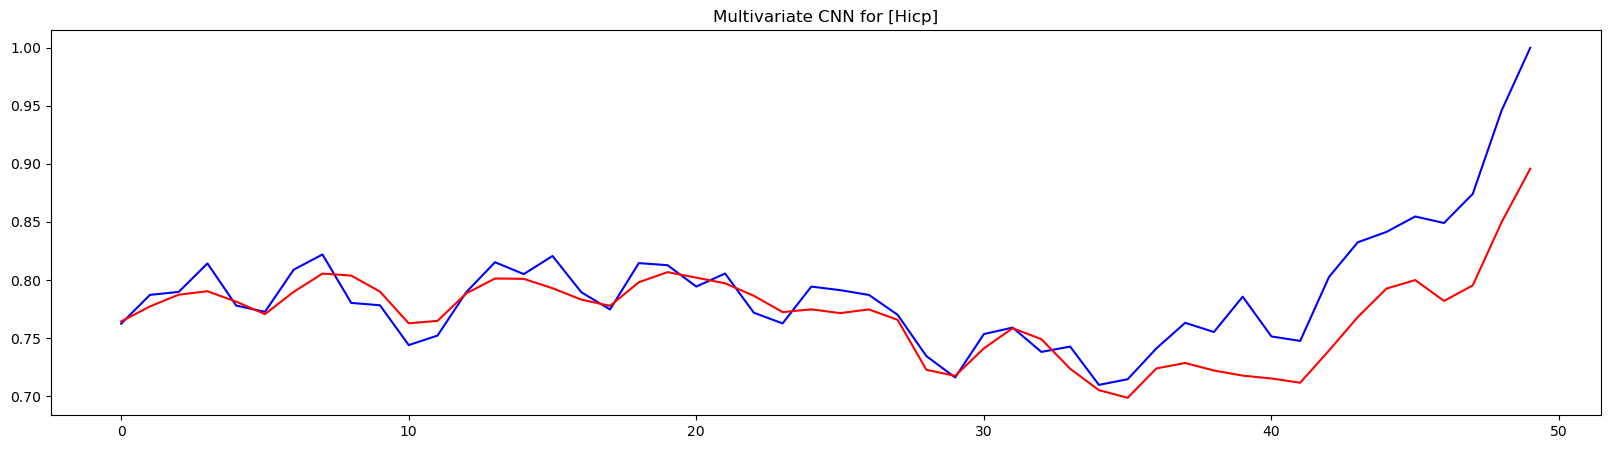




Cpi cols are ['Cpi', 'Energy Price Index']
Hicp cols are ['Hicp', 'Energy Price Index']


Multivariate CNN MSE for [Cpi]:0.0013576214
Multivariate CNN RMSE for [Cpi]:0.0368459142496393
Multivariate CNN MAE for [Cpi]:0.025360217


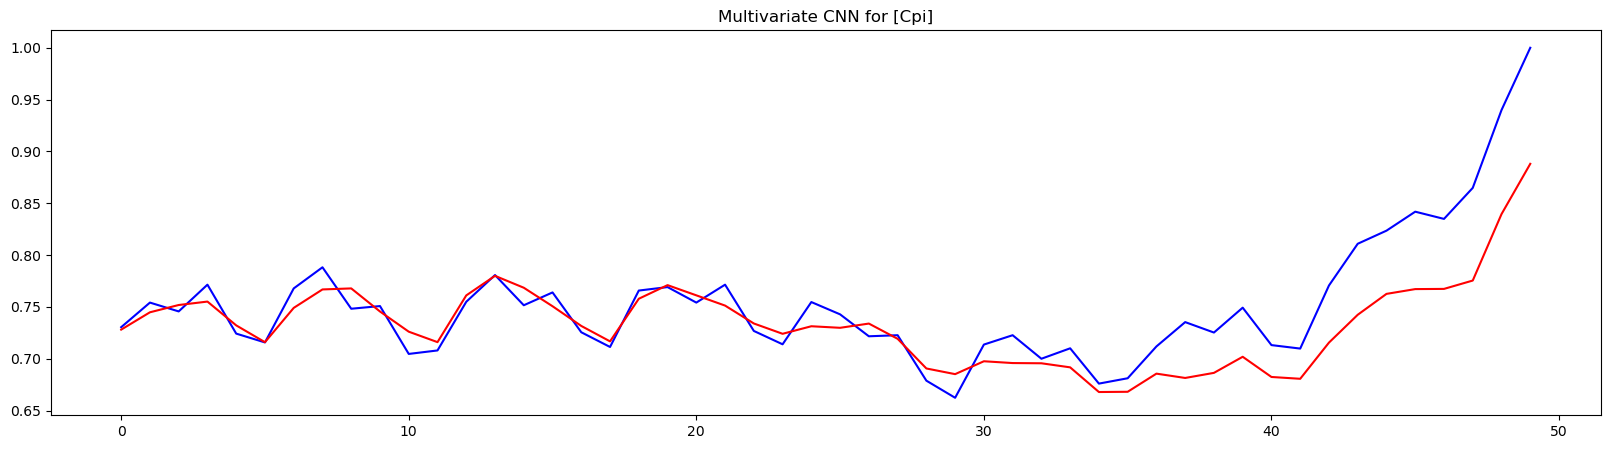

Multivariate CNN MSE for [Hicp]:0.0012775711
Multivariate CNN RMSE for [Hicp]:0.03574312630968202
Multivariate CNN MAE for [Hicp]:0.02645925


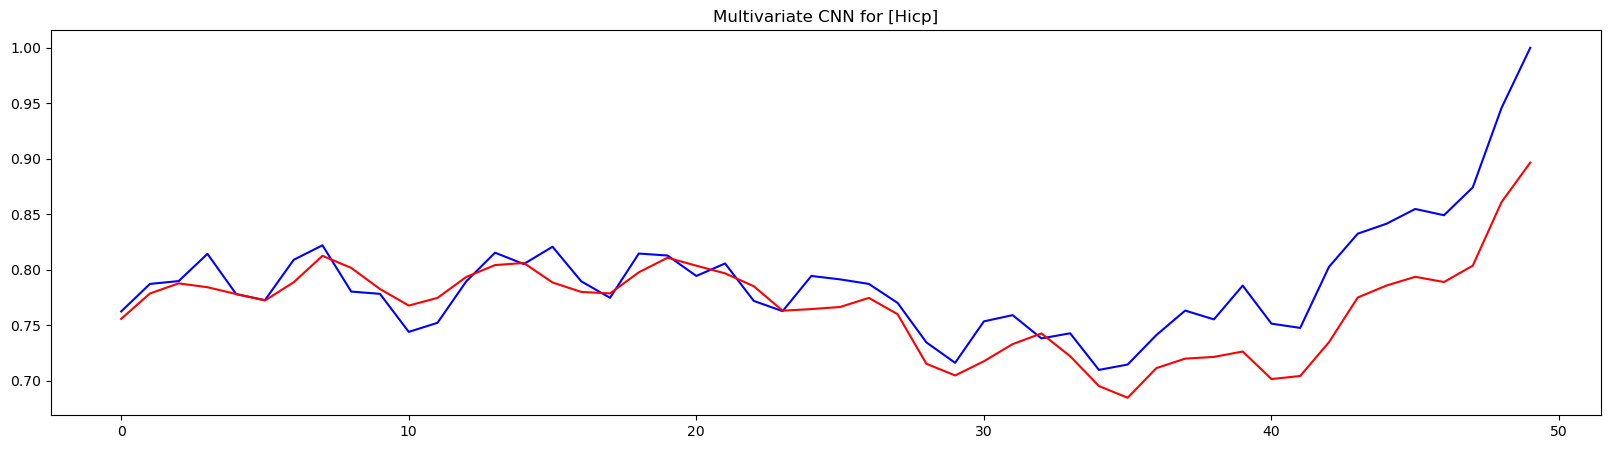




Cpi cols are ['Cpi', 'Unemployment Rate']
Hicp cols are ['Hicp', 'Unemployment Rate']


Multivariate CNN MSE for [Cpi]:0.0017635765
Multivariate CNN RMSE for [Cpi]:0.04199495833148889
Multivariate CNN MAE for [Cpi]:0.030104758


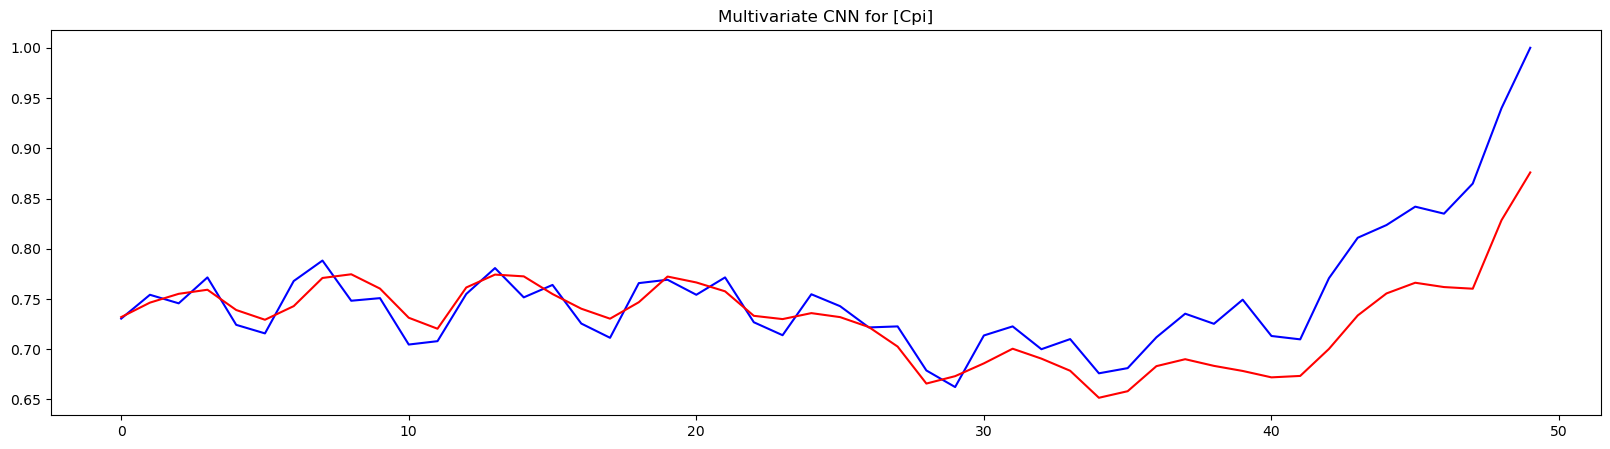

Multivariate CNN MSE for [Hicp]:0.0020912425
Multivariate CNN RMSE for [Hicp]:0.04573010459338478
Multivariate CNN MAE for [Hicp]:0.03425605


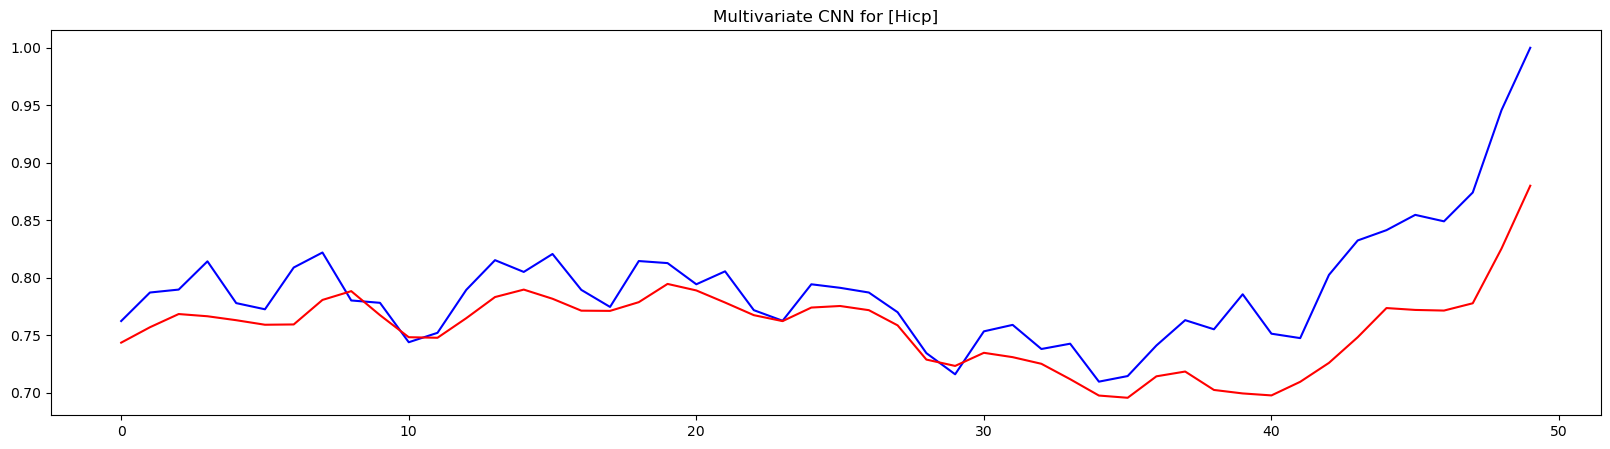




Cpi cols are ['Cpi', 'Gdp']
Hicp cols are ['Hicp', 'Gdp']


Multivariate CNN MSE for [Cpi]:0.0025486506
Multivariate CNN RMSE for [Cpi]:0.05048416192831225
Multivariate CNN MAE for [Cpi]:0.034884166


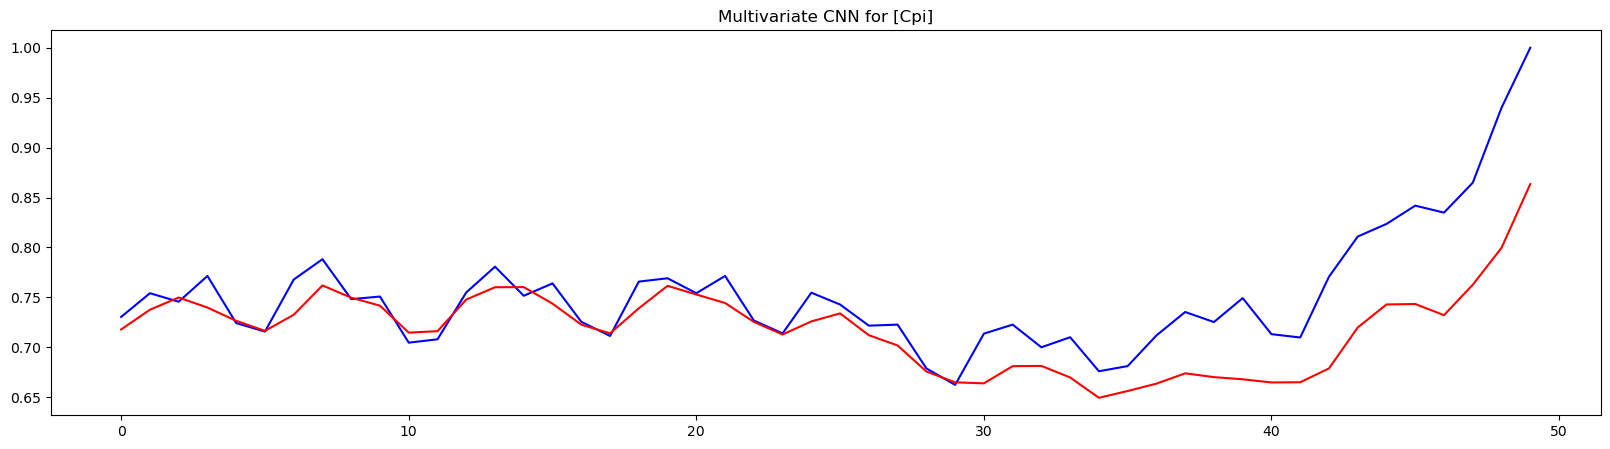

Multivariate CNN MSE for [Hicp]:0.0015693201
Multivariate CNN RMSE for [Hicp]:0.039614645000264403
Multivariate CNN MAE for [Hicp]:0.030123895


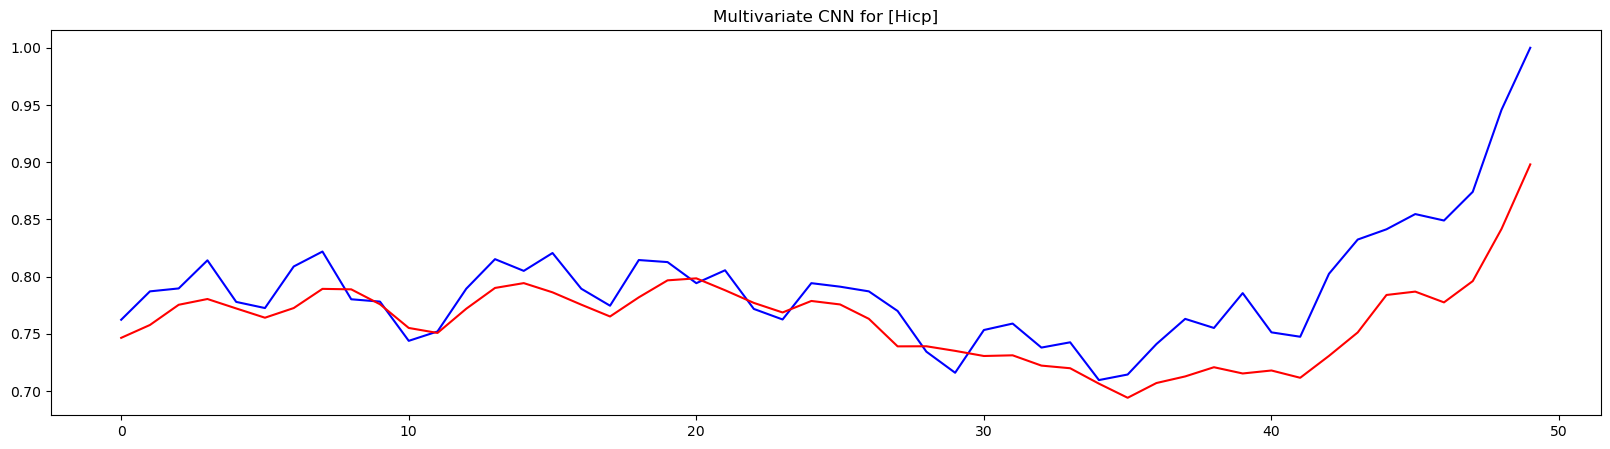




Cpi cols are ['Cpi', 'Rent Price']
Hicp cols are ['Hicp', 'Rent Price']


Multivariate CNN MSE for [Cpi]:0.0022278526
Multivariate CNN RMSE for [Cpi]:0.047200133333040586
Multivariate CNN MAE for [Cpi]:0.033321038


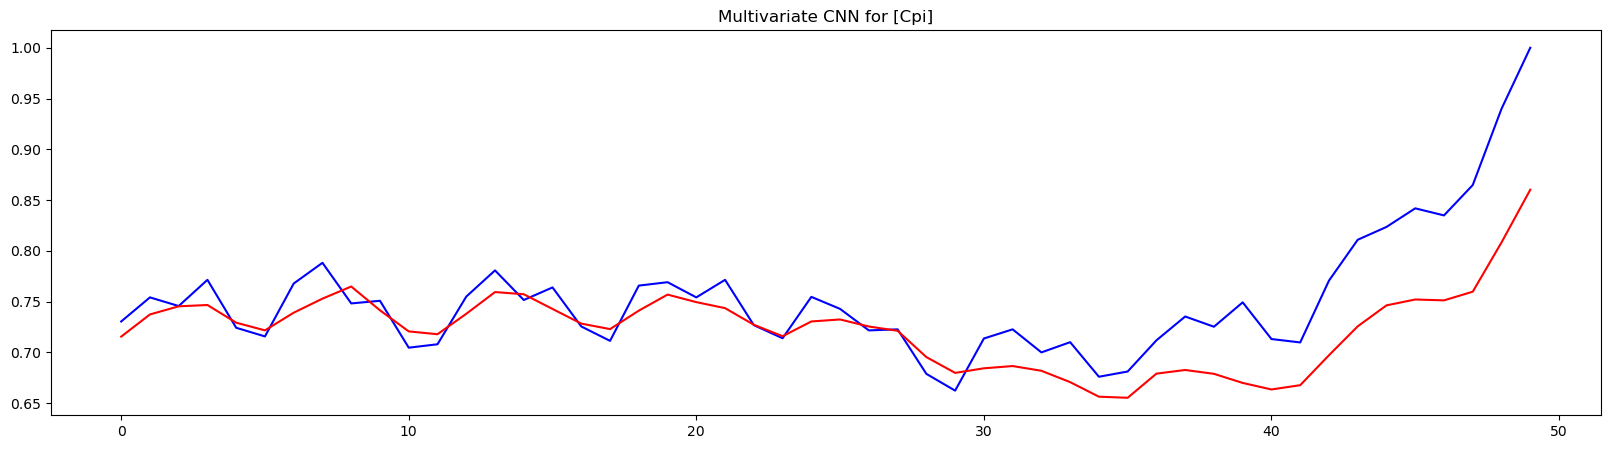

Multivariate CNN MSE for [Hicp]:0.00075771066
Multivariate CNN RMSE for [Hicp]:0.027526544624146766
Multivariate CNN MAE for [Hicp]:0.020457644


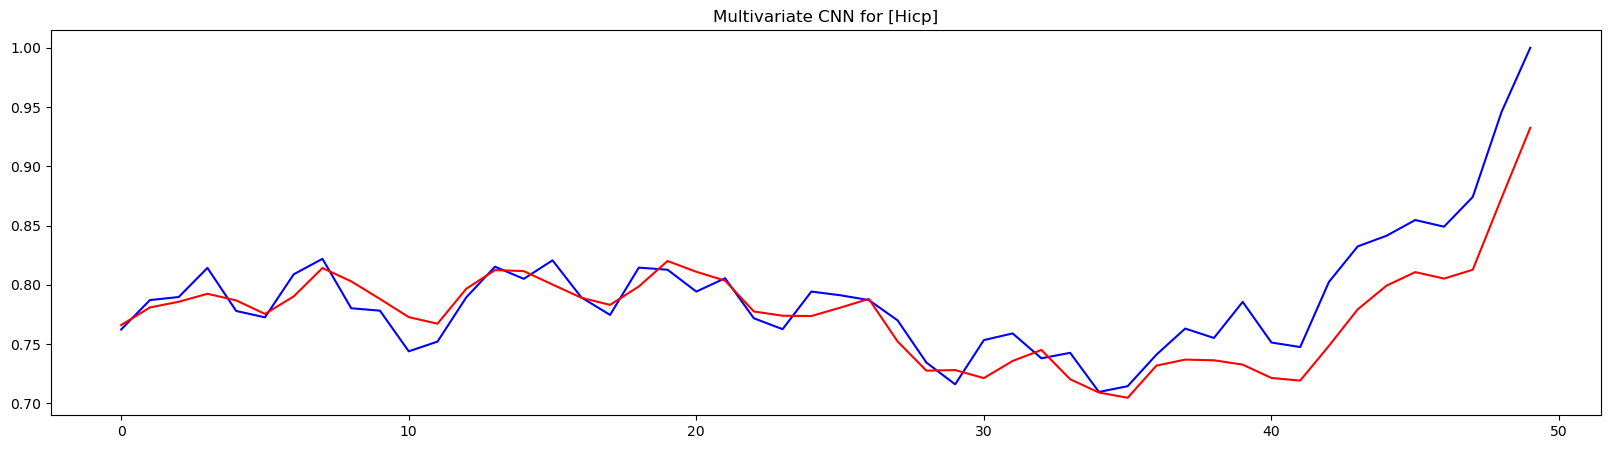




Cpi cols are ['Cpi', 'House Prices']
Hicp cols are ['Hicp', 'House Prices']


Multivariate CNN MSE for [Cpi]:0.0011980514
Multivariate CNN RMSE for [Cpi]:0.034612878830355624
Multivariate CNN MAE for [Cpi]:0.02554296


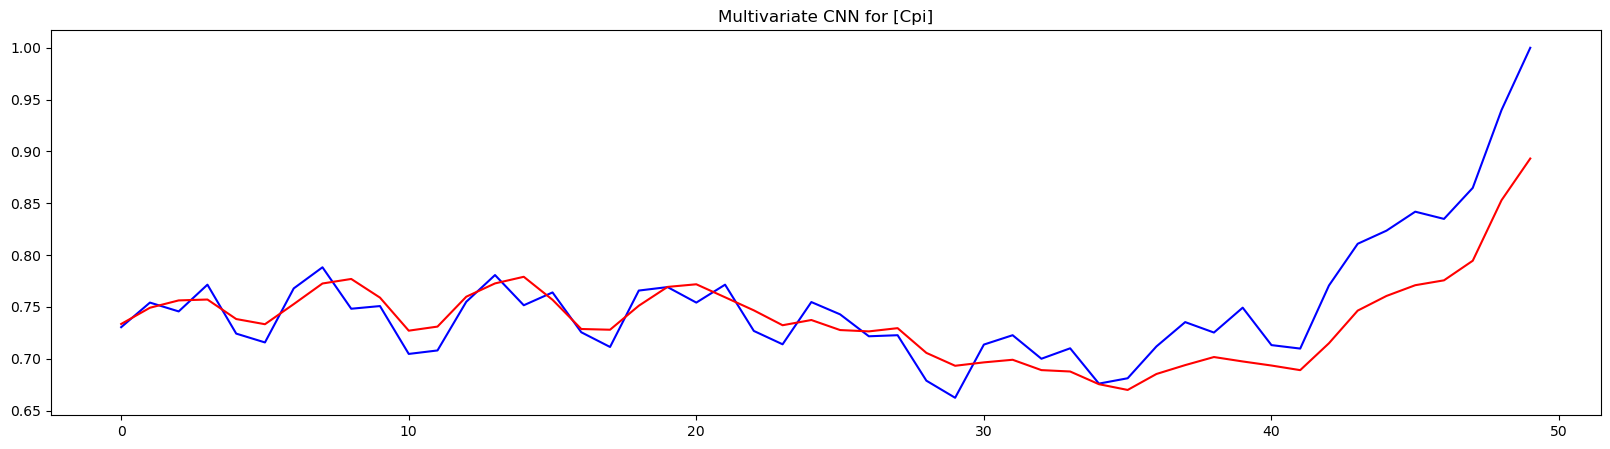

Multivariate CNN MSE for [Hicp]:0.0017947708
Multivariate CNN RMSE for [Hicp]:0.04236473563772431
Multivariate CNN MAE for [Hicp]:0.03075416


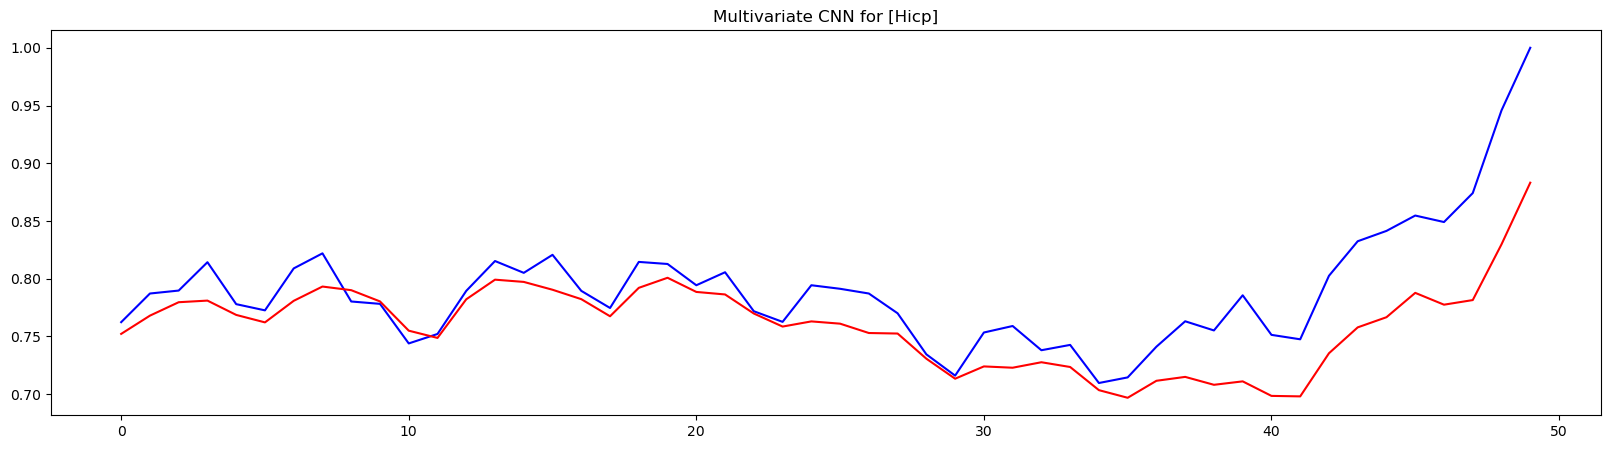




Cpi cols are ['Cpi', 'Lci']
Hicp cols are ['Hicp', 'Lci']


Multivariate CNN MSE for [Cpi]:0.00069837266
Multivariate CNN RMSE for [Cpi]:0.026426741446201746
Multivariate CNN MAE for [Cpi]:0.020116962


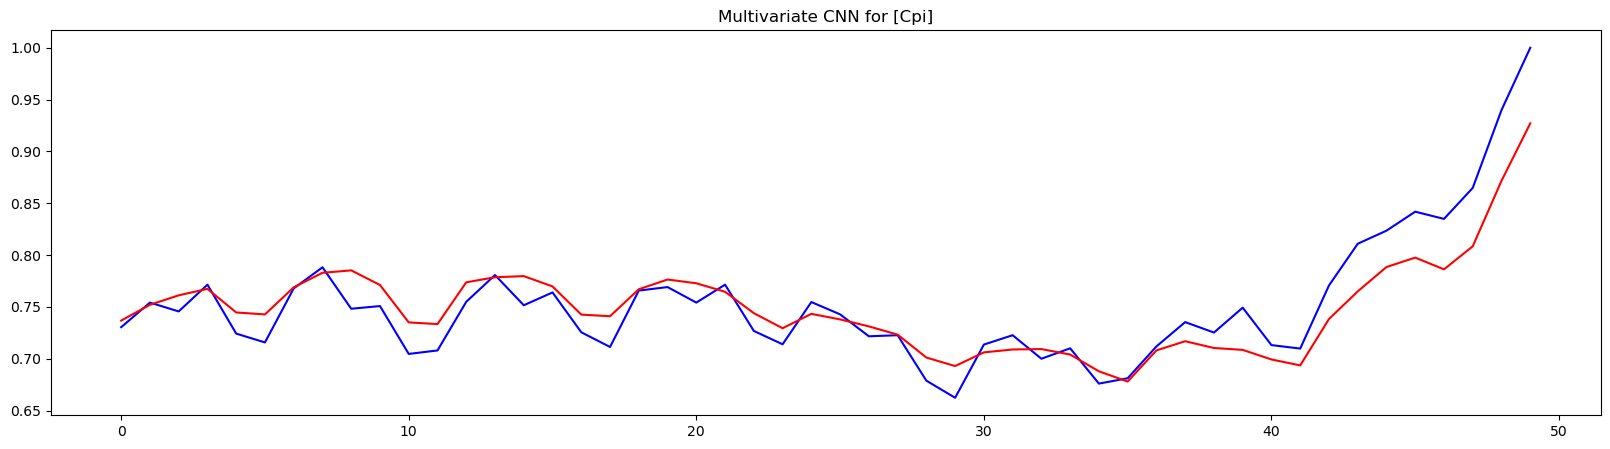

Multivariate CNN MSE for [Hicp]:0.0022234616
Multivariate CNN RMSE for [Hicp]:0.04715359618892435
Multivariate CNN MAE for [Hicp]:0.037104916


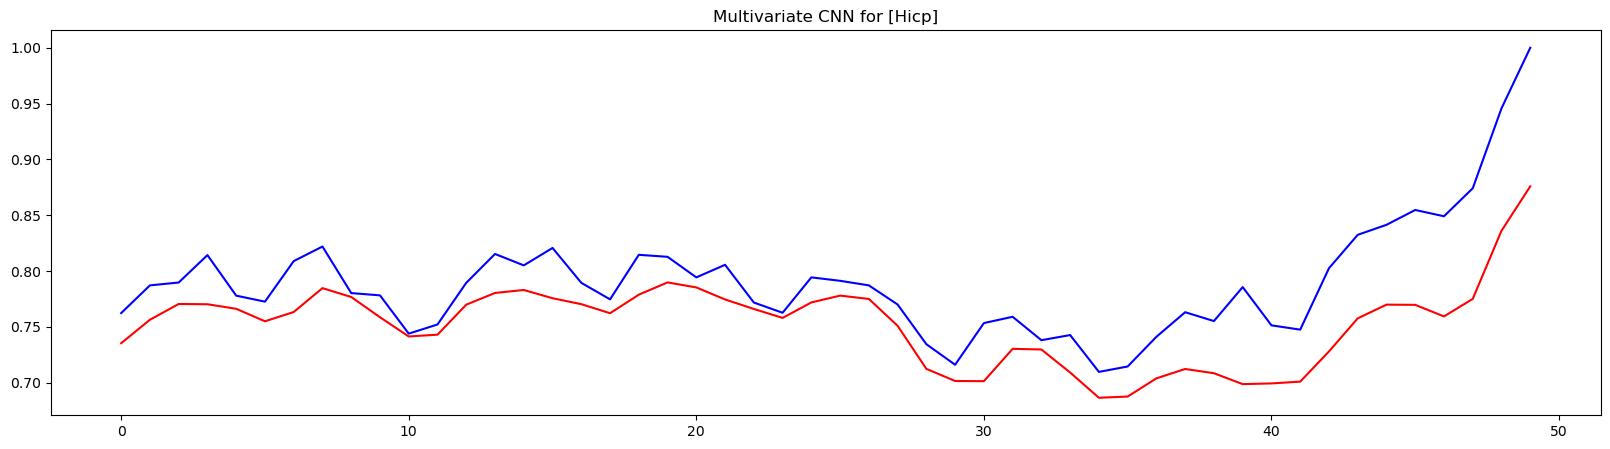

In [18]:
CNN_for_each_index()

In [21]:
# prediction of indexes using in each iteration an additional external factor
cols = ['Food Price Index','Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']
def CNN_adding_cols():
    
    cpi_cols = ['Cpi']
    hicp_cols = ['Hicp']
    
    for col in cols:
        
        cpi_cols.append(col)
        print('Cpi cols are', cpi_cols)     
        
        hicp_cols.append(col)
        print('Hicp cols are', hicp_cols)
        print('\n')
        
        cpi_inflation_values = cpi_inflation[cpi_cols]
        hicp_inflation_values = hicp_inflation[hicp_cols]
        
        datasets = [cpi_inflation_values, hicp_inflation_values]
        CNN()
        
        print('\n\n')

Cpi cols are ['Cpi', 'Food Price Index']
Hicp cols are ['Hicp', 'Food Price Index']


Multivariate CNN MSE for [Cpi]:0.0016239716
Multivariate CNN RMSE for [Cpi]:0.04029853124587289
Multivariate CNN MAE for [Cpi]:0.028193174


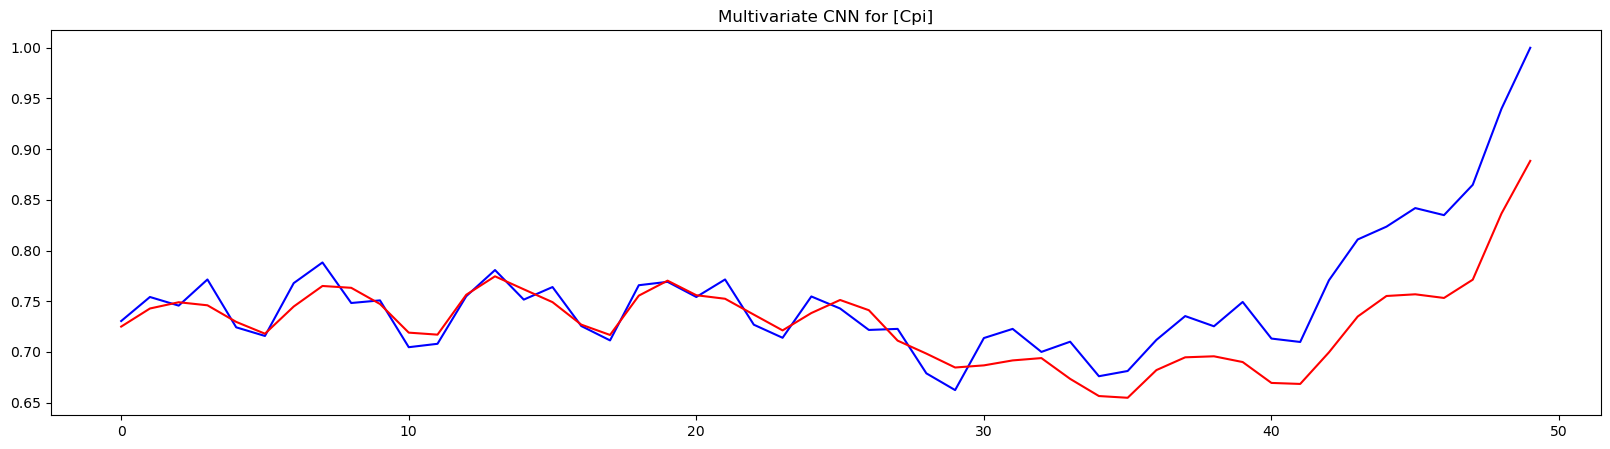

Multivariate CNN MSE for [Hicp]:0.0021962584
Multivariate CNN RMSE for [Hicp]:0.046864255031266136
Multivariate CNN MAE for [Hicp]:0.037557196


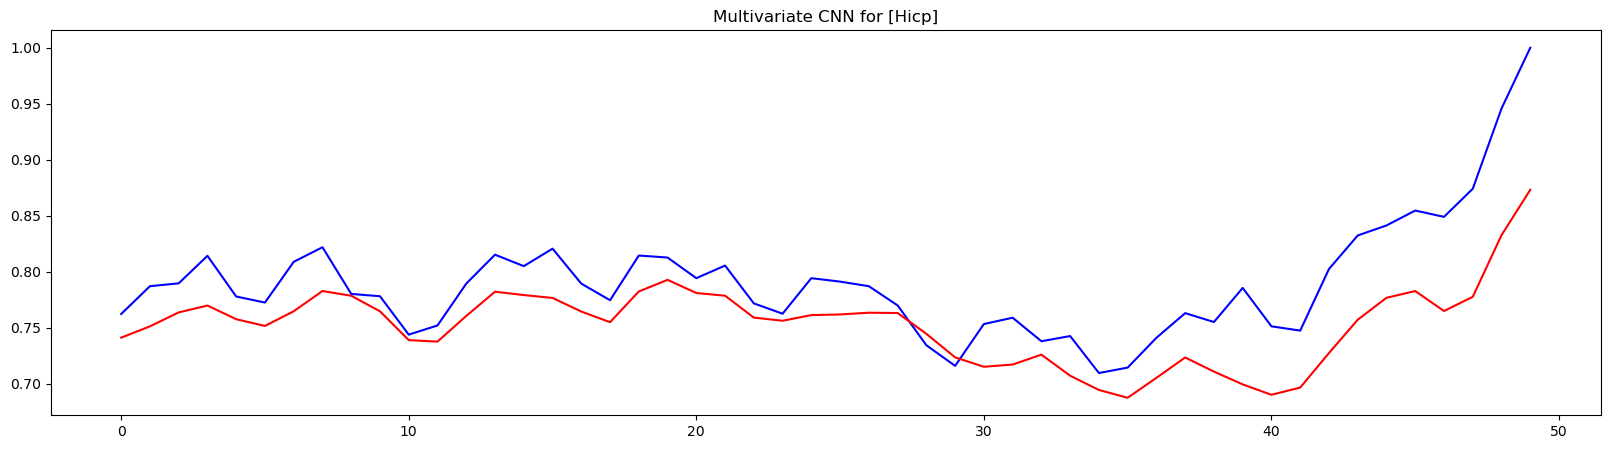




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index']


Multivariate CNN MSE for [Cpi]:0.000987294
Multivariate CNN RMSE for [Cpi]:0.0314212350745793
Multivariate CNN MAE for [Cpi]:0.023176942


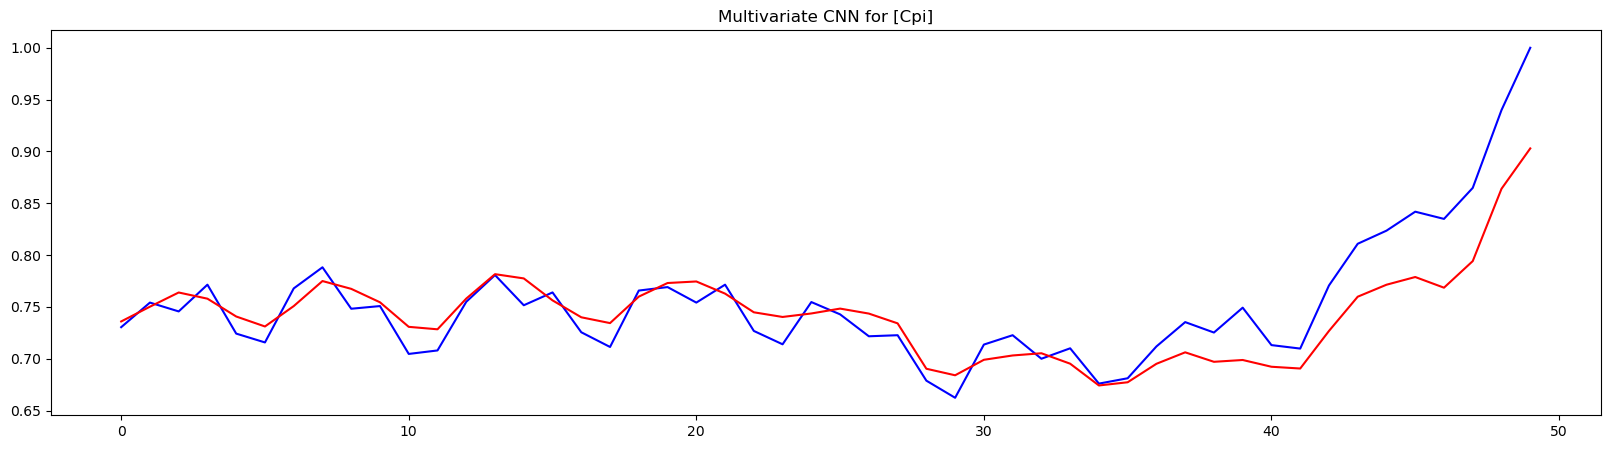

Multivariate CNN MSE for [Hicp]:0.0023682388
Multivariate CNN RMSE for [Hicp]:0.048664553368653087
Multivariate CNN MAE for [Hicp]:0.03970778


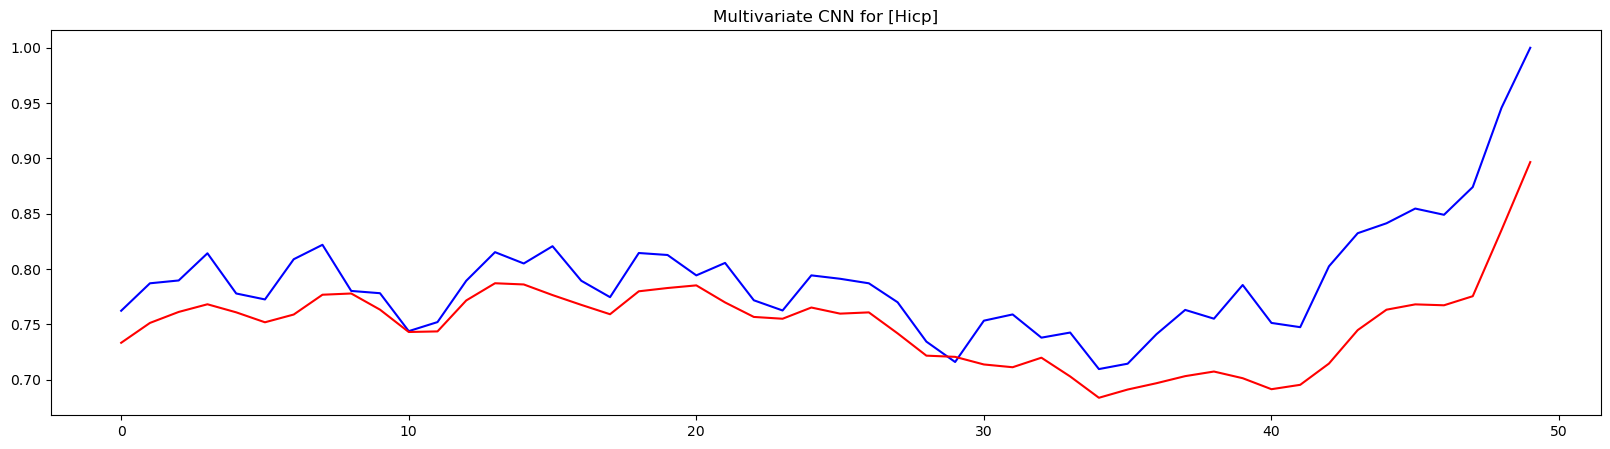




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate']


Multivariate CNN MSE for [Cpi]:0.0010220357
Multivariate CNN RMSE for [Cpi]:0.03196929341867697
Multivariate CNN MAE for [Cpi]:0.022162471


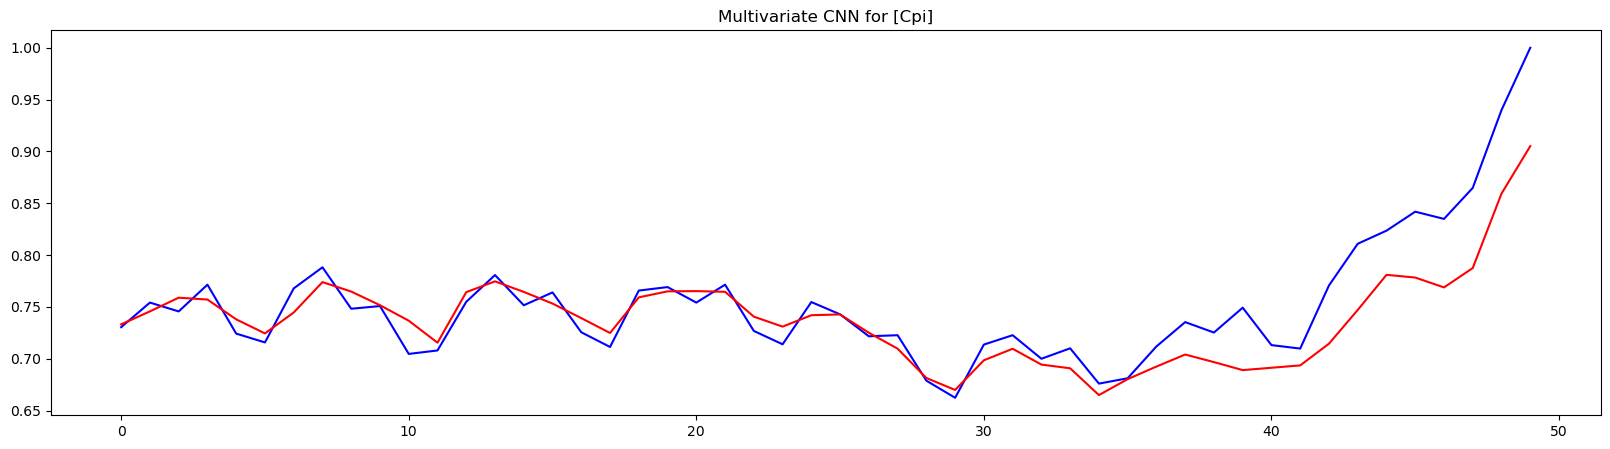

Multivariate CNN MSE for [Hicp]:0.0022845021
Multivariate CNN RMSE for [Hicp]:0.04779646582021462
Multivariate CNN MAE for [Hicp]:0.03946844


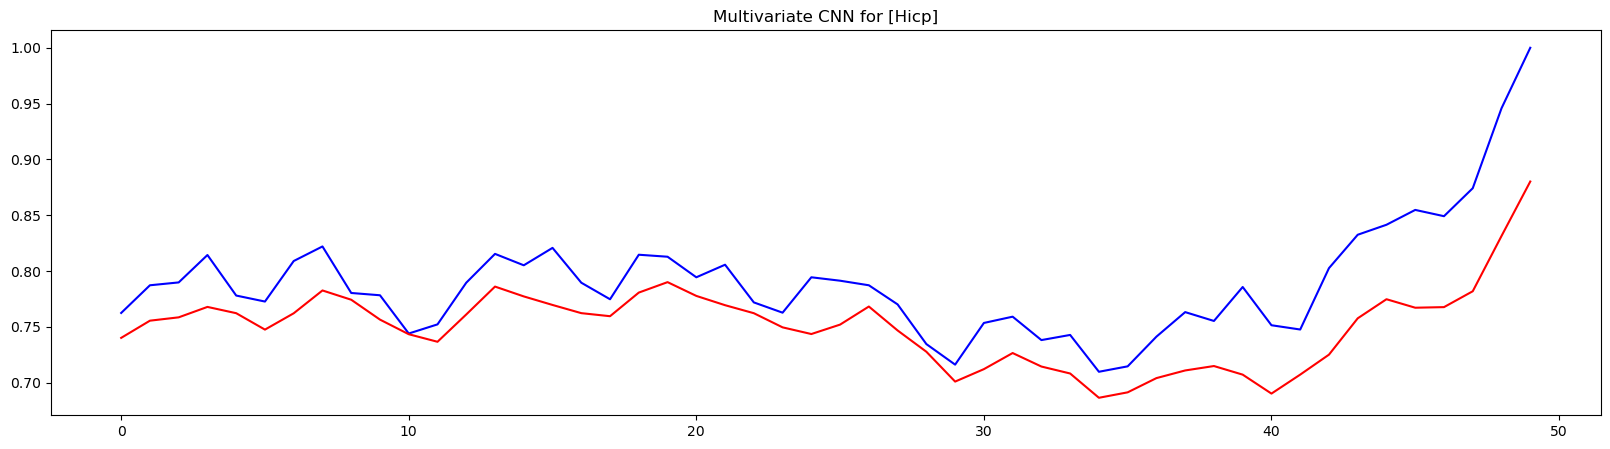




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp']


Multivariate CNN MSE for [Cpi]:0.0013975758
Multivariate CNN RMSE for [Cpi]:0.037384165549530564
Multivariate CNN MAE for [Cpi]:0.027005615


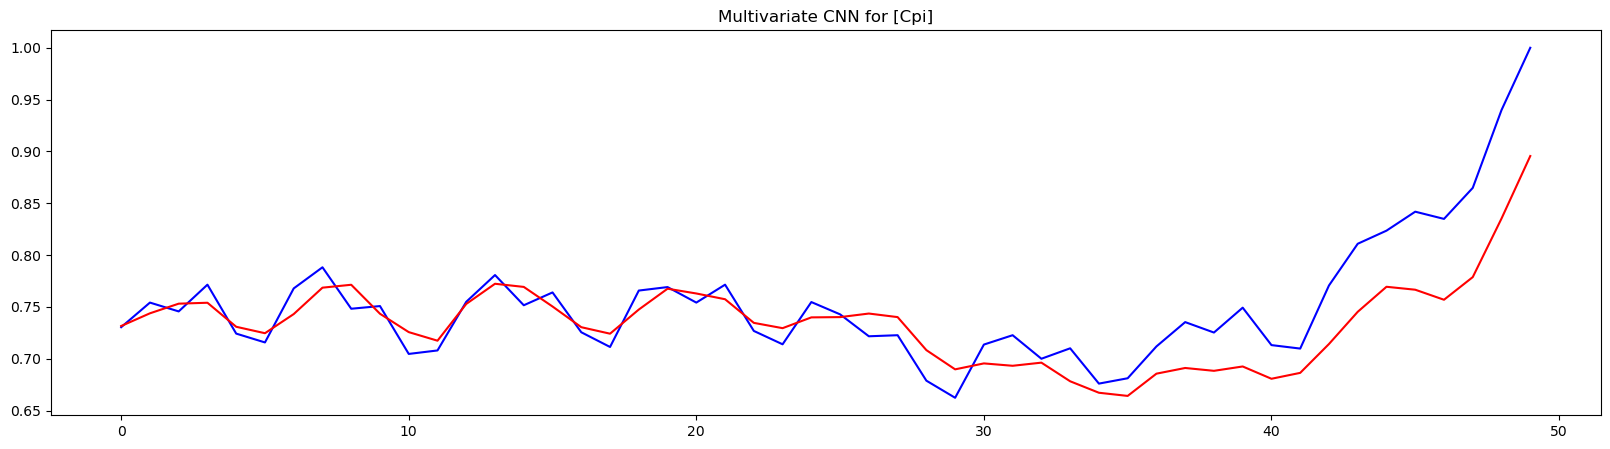

Multivariate CNN MSE for [Hicp]:0.0008122631
Multivariate CNN RMSE for [Hicp]:0.02850023002685923
Multivariate CNN MAE for [Hicp]:0.018985335


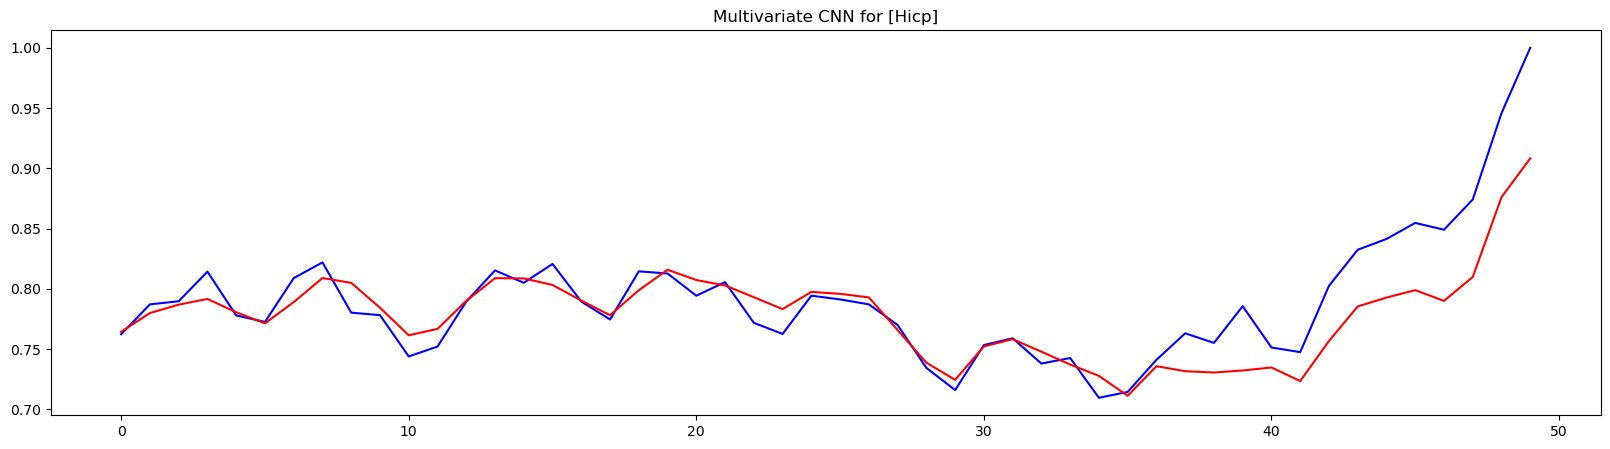




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price']


Multivariate CNN MSE for [Cpi]:0.0025734943
Multivariate CNN RMSE for [Cpi]:0.05072961988595865
Multivariate CNN MAE for [Cpi]:0.040977184


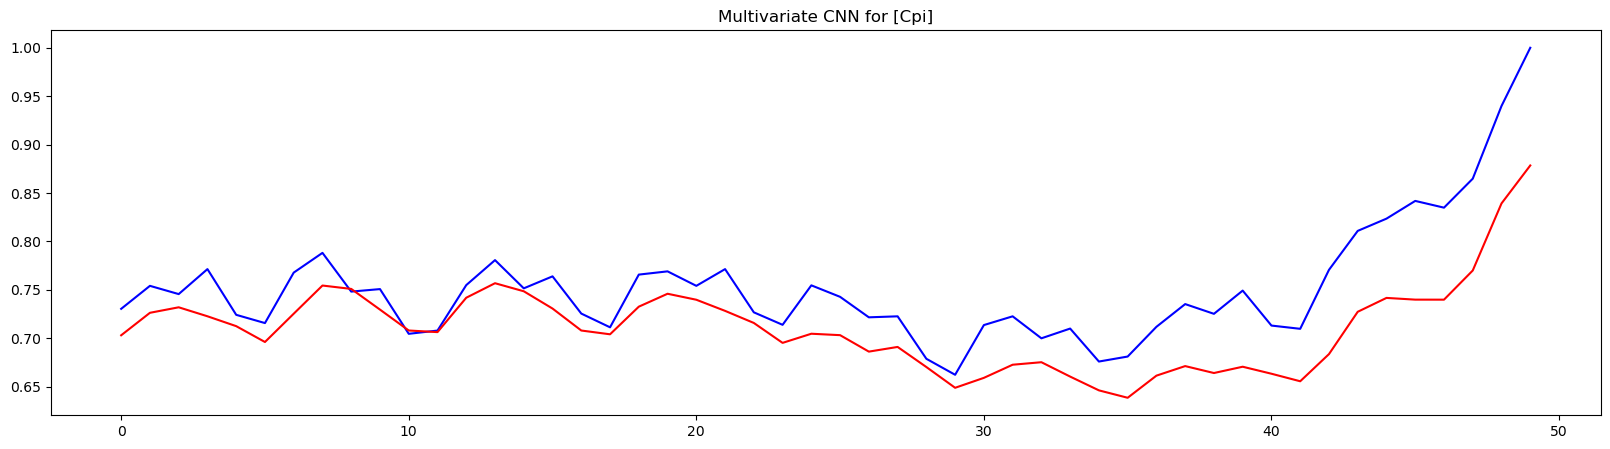

Multivariate CNN MSE for [Hicp]:0.0016696726
Multivariate CNN RMSE for [Hicp]:0.04086162687208562
Multivariate CNN MAE for [Hicp]:0.031188855


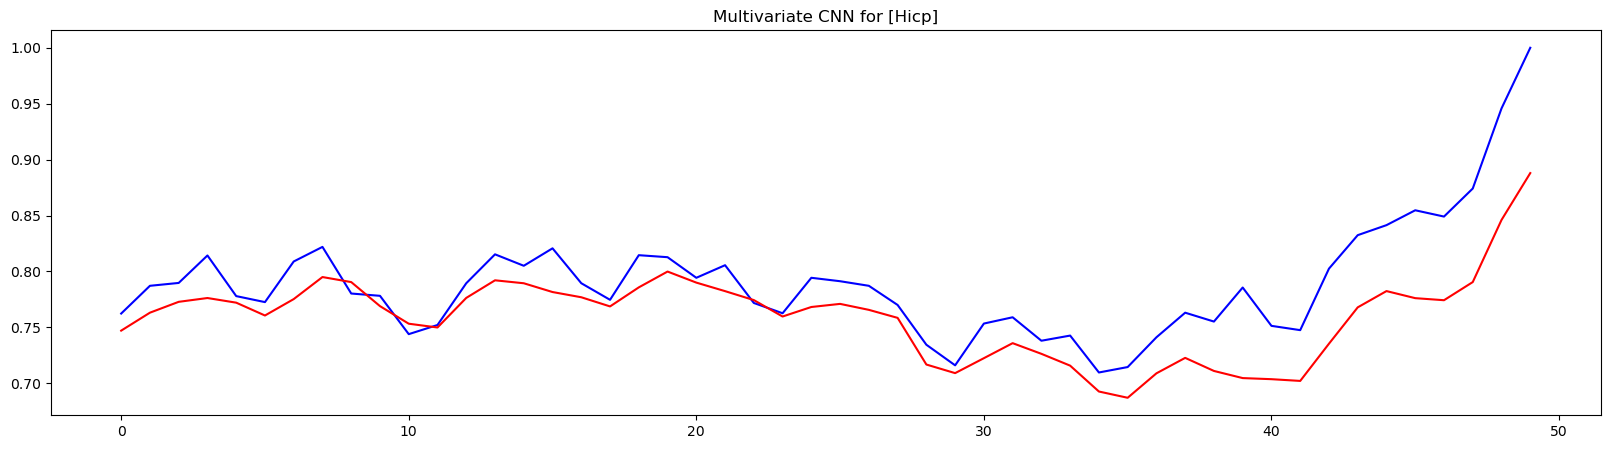




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices']


Multivariate CNN MSE for [Cpi]:0.0023574901
Multivariate CNN RMSE for [Cpi]:0.04855399188435698
Multivariate CNN MAE for [Cpi]:0.037104063


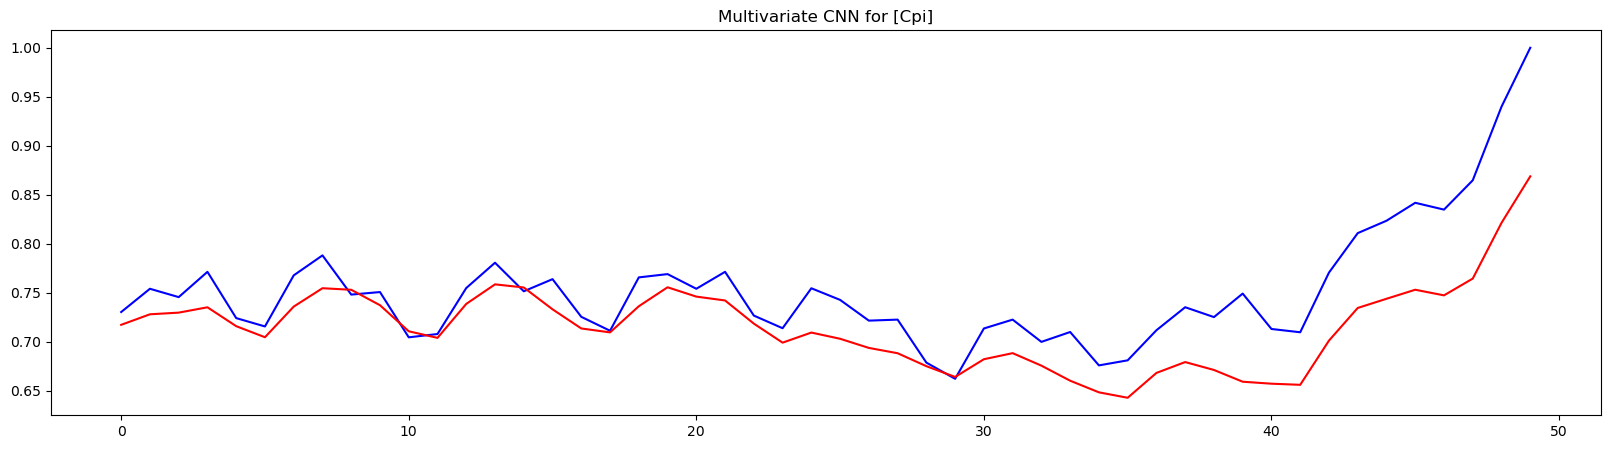

Multivariate CNN MSE for [Hicp]:0.0021002258
Multivariate CNN RMSE for [Hicp]:0.04582822024523764
Multivariate CNN MAE for [Hicp]:0.03652193


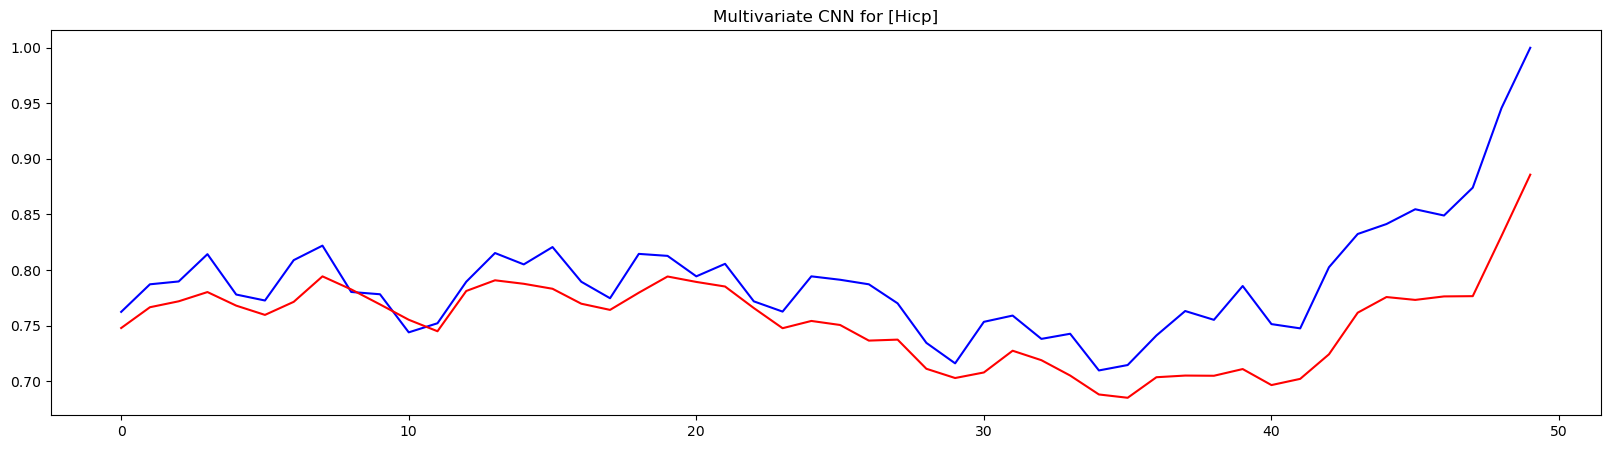




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']


Multivariate CNN MSE for [Cpi]:0.004016745
Multivariate CNN RMSE for [Cpi]:0.06337779504069312
Multivariate CNN MAE for [Cpi]:0.052410383


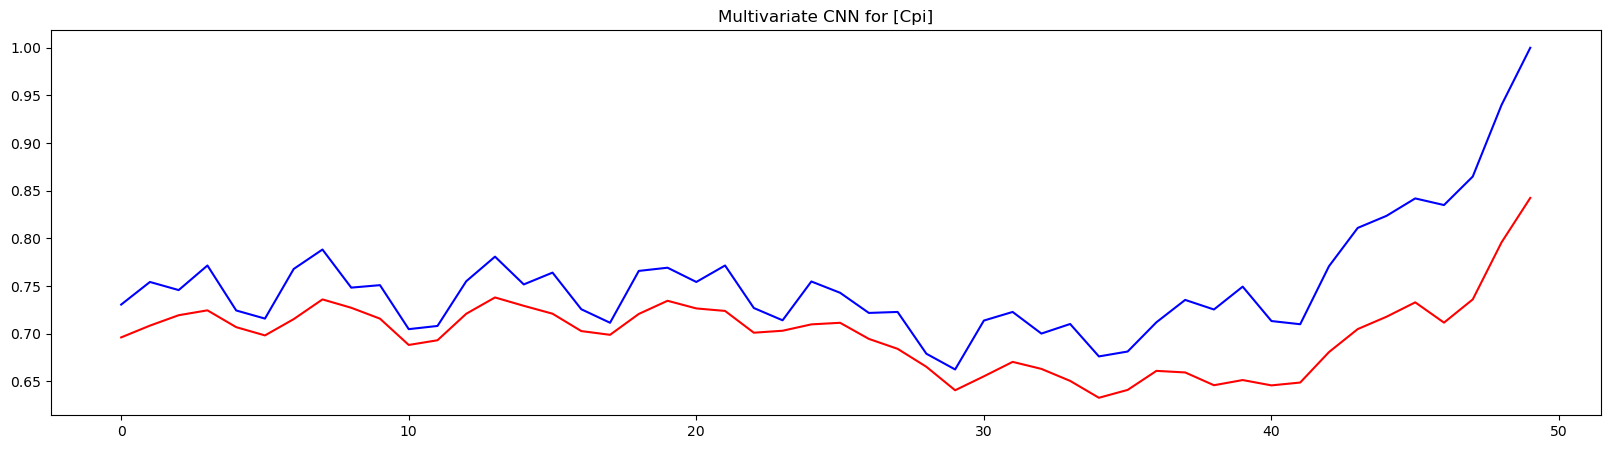

Multivariate CNN MSE for [Hicp]:0.0011978076
Multivariate CNN RMSE for [Hicp]:0.034609357220858276
Multivariate CNN MAE for [Hicp]:0.025230203


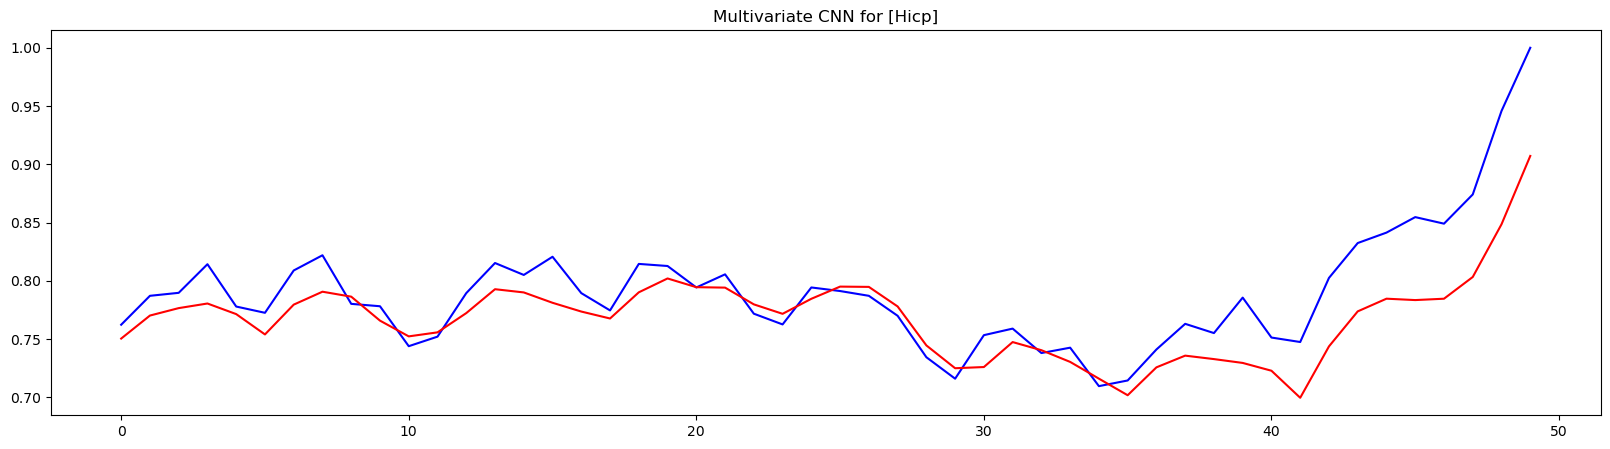

In [22]:
CNN_adding_cols()